In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 영역 찾기

In [6]:
!pip install opencv-python
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 41.8 MB/s eta 0:00:00


In [26]:
!sudo apt-get -qq -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share

In [27]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')

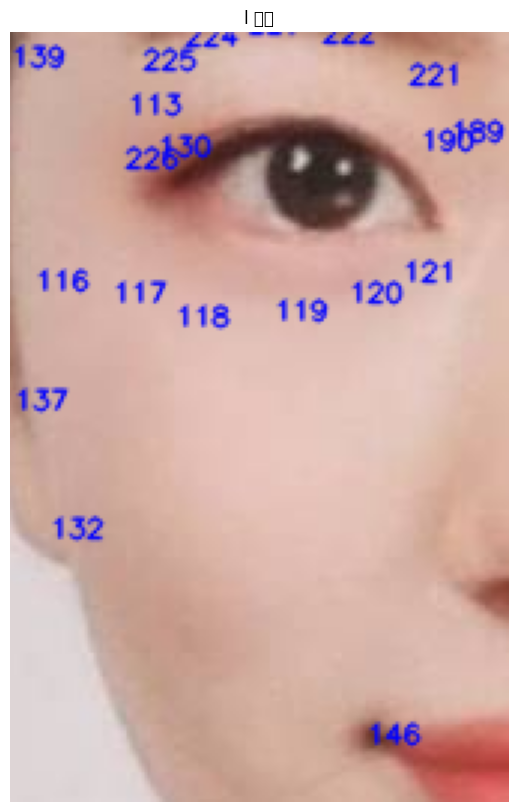

In [45]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
def crop_and_show_part(image_path, part='eye'):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 랜드마크 탐지
    results = face_mesh.process(image_rgb)
    if not results.multi_face_landmarks:
        print("❌ 얼굴 인식 실패")
        return

    face_landmarks = results.multi_face_landmarks[0]

    # 부위별 번호 정의 (필요 시 수정)
    part_indices = {
        'f': [8, 9, 10, 107, 66, 105, 63, 70, 71, 109, 108, 151, 296, 334, 293, 300, 299,
            383, 368, 389, 356, 337, 276, 283, 282, 295, 285, 336]
            + list(range(65, 69)),

        'n': [0, 1, 2, 5, 6, 45, 275, 274, 164, 165, 97, 98, 99,
            2, 94, 240, 218, 219, 220, 237, 218, 134,399, 398],

        'l': [116, 117, 118, 119, 120, 121, 130, 132,
            226, 113, 225, 224, 223, 222, 221, 189, 190, 137, 139, 146],

        'r': [345, 346, 347, 348, 349, 350, 359, 361,
            447, 366, 436, 435, 414, 398, 397]+ list(range(380,390)),

        'm':  [0, 17, 170, 175 ,364, 335, 172, 152, 395, 396, 397, 400]
    }

    if part not in part_indices:
        print(f"부위 이름 잘못됨: {part}")
        return

    # 해당 부위만 좌표 수집
    points = [
        (int(face_landmarks.landmark[i].x * image.shape[1]),
         int(face_landmarks.landmark[i].y * image.shape[0]))
        for i in part_indices[part]
    ]

    # 해당 부위 영역 잘라내기
    x_min = min(p[0] for p in points)
    x_max = max(p[0] for p in points)
    y_min = min(p[1] for p in points)
    y_max = max(p[1] for p in points)

    cropped = image[y_min-10:y_max+10, x_min-10:x_max+10].copy()

    # 확대해서 번호 표시
    for idx, (x, y) in zip(part_indices[part], points):
        cv2.putText(cropped, str(idx), (x - x_min, y - y_min),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)

    # 시각화
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'{part} 확대')
    plt.show()

# 예시 실행
crop_and_show_part('/content/drive/MyDrive/수지증명사진.jpg', part='l')  # 부위: 'left_eye', 'right_eye', 'nose', 'mouth'

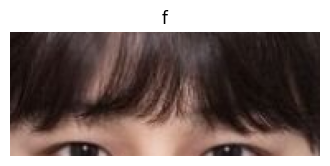

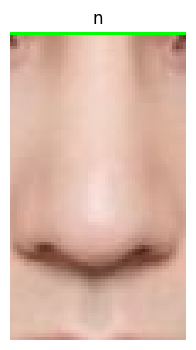

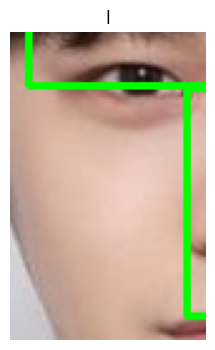

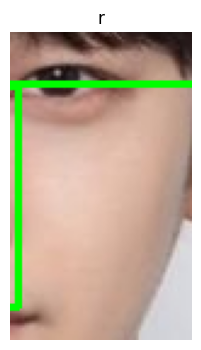

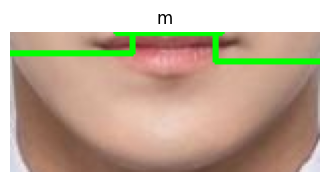

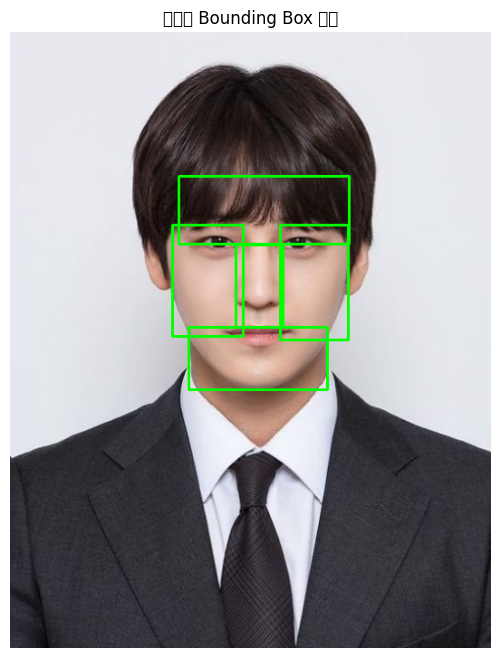

In [42]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# 부위별 랜드마크 번호
part_indices = {
    'f': [8, 9, 10, 107, 66, 105, 63, 70, 71, 109, 108, 151, 296, 334, 293, 300, 299,
            383, 368, 389, 356, 337, 276, 283, 282, 295, 285, 336]
            + list(range(65, 69)),

        'n': [0, 1, 2, 5, 6, 45, 275, 274, 164, 165, 97, 98, 99,
            2, 94, 240, 218, 219, 220, 237, 218, 134,399, 398],

        'l': [116, 117, 118, 119, 120, 121, 128, 130, 132,
            226, 113, 225, 224, 223, 222, 221, 189, 190, 137, 139, 146],

        'r': [345, 346, 347, 348, 349, 350, 359, 361,
            447, 366, 436, 435, 414, 398, 397]+ list(range(380,390)),

        'm':  [0, 17, 170, 175 ,364, 335, 172, 152, 395, 396, 397,400]
}

# 부위별 사각형 크롭
def get_part_bounding_box(image, landmarks, indices):
    points = np.array([
        [int(landmarks.landmark[i].x * image.shape[1]),
         int(landmarks.landmark[i].y * image.shape[0])]
        for i in indices
    ])
    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)

    cropped = image[y_min:y_max, x_min:x_max].copy()

    return cropped, (x_min, y_min, x_max, y_max)

# 부위별 시각화
def detect_and_visualize_parts_bbox(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(image_rgb)
    if not results.multi_face_landmarks:
        print("얼굴 인식 실패")
        return

    face_landmarks = results.multi_face_landmarks[0]

    for part, indices in part_indices.items():
        cropped_part, bbox = get_part_bounding_box(image, face_landmarks, indices)

        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(cropped_part, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'{part}')
        plt.show()

        # 선택사항: 원본 이미지에 사각형 표시 (확인용)
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # 전체 얼굴에 박스 표시 결과 (옵션)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('부위별 Bounding Box 표시')
    plt.show()

# 테스트 실행
detect_and_visualize_parts_bbox('/content/drive/MyDrive/남자증명사진.jpg')  # 경로 맞춰서 사용
